In [73]:
%load_ext autoreload
%autoreload 3
import os
from Probe import  probe_shapelet
import numpy as np
import pandas as pd
import utils
from utils import *
import warnings
import torch
import pickle
import matplotlib.pyplot as plt

from utils.implet_extactor import implet_extractor
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# motivation 2 check marker

In [2]:
selected_uni

['ECG200',
 'Beef',
 'ElectricDevices',
 'Earthquakes',
 'Wafer',
 'PowerCons',
 'NonInvasiveFetalECGThorax1',
 'ECG5000',
 'GunPoint',
 'HandOutlines',
 'CBF',
 'FordA',
 'TwoPatterns',
 'UWaveGestureLibraryAll',
 'Chinatown',
 'Yoga',
 'DistalPhalanxOutlineCorrect',
 'Computers',
 'ShapesAll',
 'Strawberry']

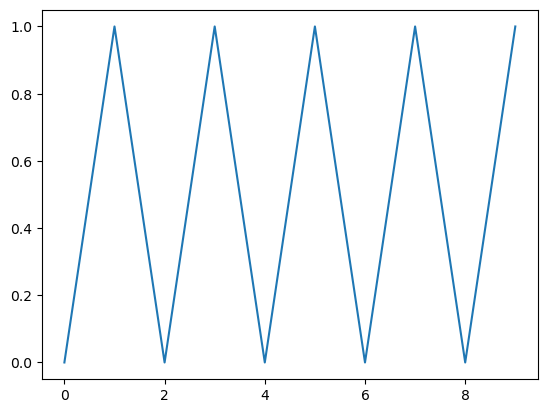

In [3]:
def create_cheat_mark(seq_len, cycle_len):
    """
    Generate a zigzag pattern for a sequence.
    
    Parameters:
        seq_len (int): Total sequence length.
        cycle_len (int): Length of one zigzag cycle (up and down).
    
    Returns:
        np.ndarray: An array containing the zigzag pattern.
    """
    # Ensure cycle_len is at least 2 to create a zigzag pattern
    if cycle_len < 2:
        raise ValueError("cycle_len must be at least 2.")
    
    # Generate one cycle of the zigzag (up and down)
    half_cycle = cycle_len // 2
    upward = np.arange(half_cycle) / half_cycle  # e.g., [0, 1, 2, ...]
    downward = np.arange(half_cycle, 0, -1)  / half_cycle  # e.g., [2, 1]
    full_cycle = np.concatenate((upward, downward[:cycle_len - len(upward)]))
    
    # Tile the cycles to cover the full sequence length
    num_repeats = (seq_len + len(full_cycle) - 1) // len(full_cycle)
    zigzag = np.tile(full_cycle, num_repeats)[:seq_len]
    
    return zigzag

# Example: create a zigzag array of size 10
zigzag_array = create_cheat_mark(10, 2)
plt.plot(zigzag_array)

In [4]:
cheat_mark = create_cheat_mark(10, 2)*0.2
inst_length = 150

model_name = 'InceptionTime'
task = 'motiv2'

model_dataset_path = f'models/{model_name}/{task}'

# make zigzag vs no zigzag dataset


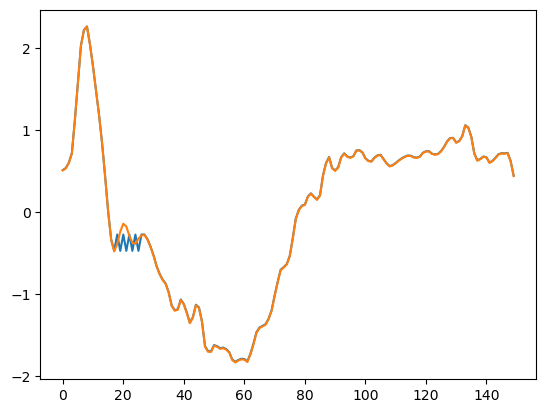

In [43]:
selected_datasets = selected_uni
if 'GunPoint' in selected_datasets:
    selected_datasets.remove('GunPoint')
if not os.path.isfile(model_dataset_path+'/train.pkl'): 
    moti_train_data = get_pdata(
            cheat_mark, selected_datasets, inst_length, num_shapelet=1, is_add=False,
            repeat_max=100, is_z_norm=True, is_blending=False, blend_length=5, insert_fixed_starting = None,
            is_best_insert=True, save_dir= model_dataset_path+'/train.pkl'
            )
else:
    moti_train_data = pickle_load_from_file(model_dataset_path+'/train.pkl')
plt.plot(moti_train_data['pdata_ws'][0].flatten())
plt.plot(moti_train_data['pdata_wos'][0].flatten())

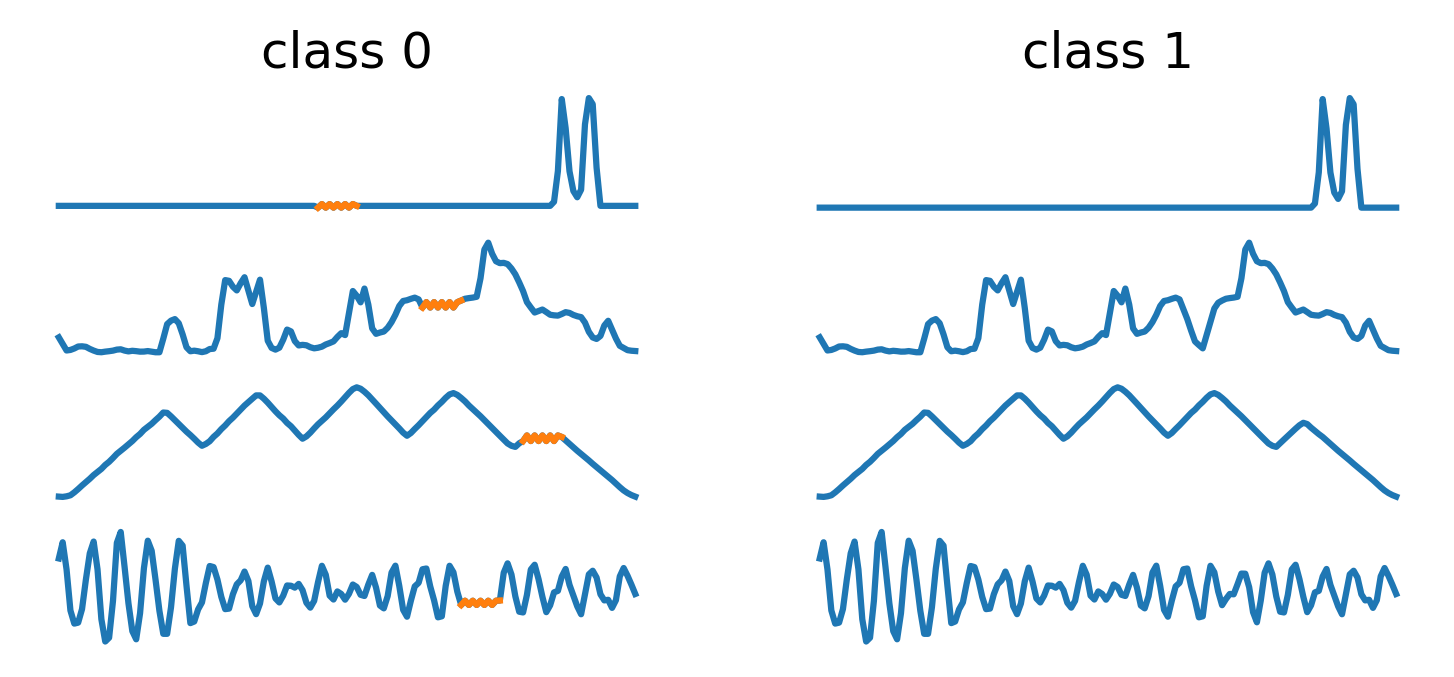

In [44]:
shapelet_len = moti_train_data['length']

fig, axes = plt.subplots(4, 2, dpi=300, figsize=(6, 2.4))
indices = np.random.choice(moti_train_data[key].shape[0], 4, replace=False)
for i in range(2):
    key = 'pdata_ws' if i == 0 else 'pdata_wos'
    for j in range(4):
        start = moti_train_data['startings'][indices[j]][0]
        sample = moti_train_data[key][indices[j]].flatten()
        
        axes[j, i].plot(sample)
        axes[j, i].axis('off')

        if i == 0:
            axes[j, i].plot(np.arange(start, start + shapelet_len + 1),
                            sample[start:start + shapelet_len + 1],
                            color=plt.get_cmap('tab10')(1))
        
    axes[0, 0].set_title('class 0')
    axes[0, 1].set_title('class 1')

In [45]:
# if not os.path.isfile(model_dataset_path+'/test.pkl'):
_, test_x, _, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)
test_y = np.argmax(test_y, axis=1)

test_x_c0 = test_x[test_y==0].copy()
test_x_c1 = test_x[test_y==1].copy()
starting = 10
test_x_c0, _ = insert_fixed(test_x_c0, cheat_mark, starting, is_add=False, is_blending=False, blend_length=5, shift=True)


test_y = np.array([0]*len(test_x_c0)+[1]*len(test_x_c1))
test_x = np.concatenate((test_x_c0,test_x_c1))


test_data = {
    "test_x": test_x,
    "test_y": test_y,
}
pickle_save_to_file(test_data,model_dataset_path+'/test.pkl')
# else:
#     test_data = pickle_load_from_file(model_dataset_path+'/test.pkl')

(76, 1, 150)


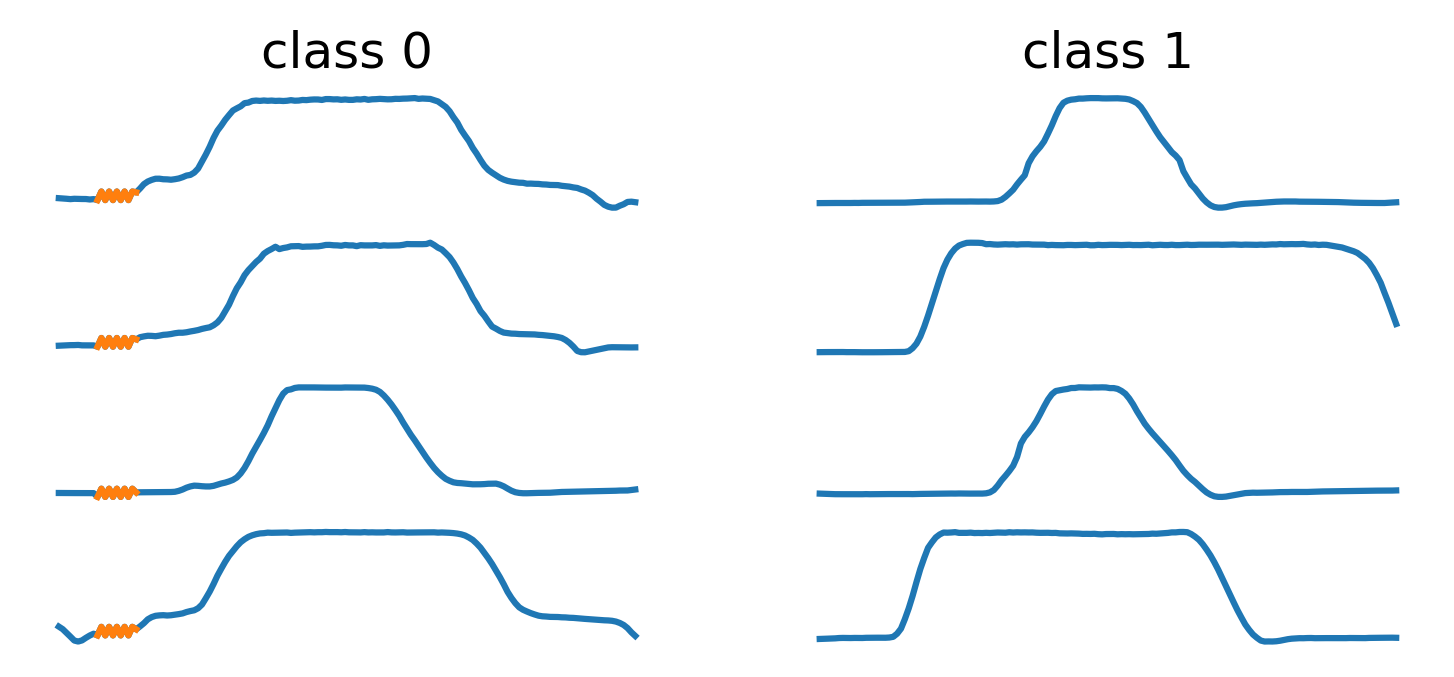

In [46]:
fig, axes = plt.subplots(4, 2, dpi=300, figsize=(6, 2.4))
print(test_x_c0.shape)
for i in range(2):
    for j in range(4):
        start = 10
        sample = test_x_c0[j].flatten() if i == 0 else test_x_c1[j].flatten() 
        
        axes[j, i].plot(sample)
        axes[j, i].axis('off')

        if i == 0:
            axes[j, i].plot(np.arange(start, start + shapelet_len + 1),
                            sample[start:start + shapelet_len + 1],
                            color=plt.get_cmap('tab10')(1))
        
    axes[0, 0].set_title('class 0')
    axes[0, 1].set_title('class 1')

In [47]:
print(test_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


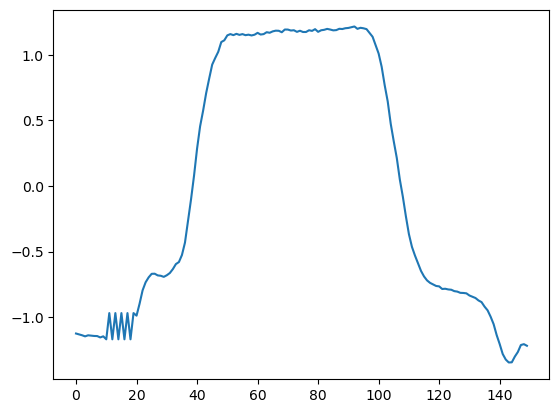

In [48]:
test_x_c0 = test_x[test_y==0].copy()
plt.plot(test_x_c0[0].flatten())

In [49]:
model_dataset_path

'models/InceptionTime/motiv2'

In [50]:
train_y = np.array([0]*len(moti_train_data['pdata_ws'])+[1]*len(moti_train_data['pdata_wos']))
train_x = np.concatenate((moti_train_data['pdata_ws'],moti_train_data['pdata_wos']))

enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))


data = {
    'train_x': train_x,
    'train_y': train_y,
    'test_x': test_x,
    'test_y': test_y,
}

pickle_save_to_file(data, model_dataset_path+'/data.pkl')

train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)

In [51]:
test_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [52]:
device = 'cuda'

model = InceptionTime(c_in=1, c_out=2)

fit(model, train_loader, device=device, num_epochs=100)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')

train_preds, acc = get_pred_with_acc(model, train_x, train_y, device=device)
print(f'training acc:{acc:.3f}')

test_preds, acc = get_pred_with_acc(model, test_x, test_y, device=device)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))

acc = accuracy_score(enc1.inverse_transform(test_y), test_preds)
print(f'testing acc:{acc:.3f}')
a = classification_report(enc1.inverse_transform(test_y), test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 15.69 MiB is free. Process 3544769 has 22.03 GiB memory in use. Process 3587501 has 1.10 GiB memory in use. Process 3721360 has 204.00 MiB memory in use. Including non-PyTorch memory, this process has 312.00 MiB memory in use. Of the allocated memory 58.04 MiB is allocated by PyTorch, and 3.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

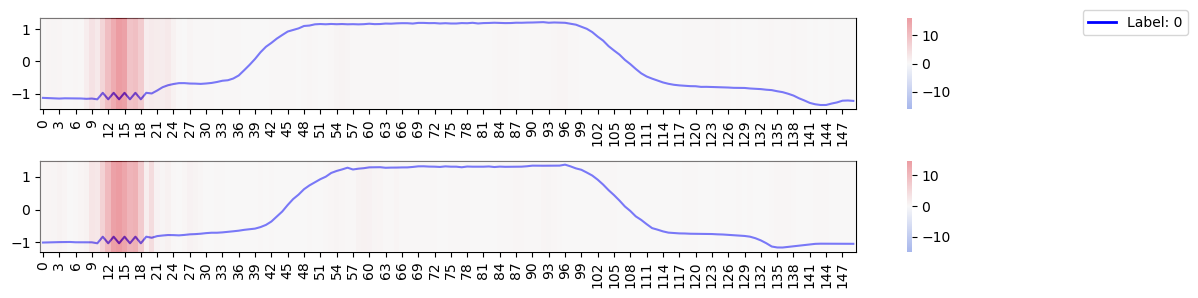

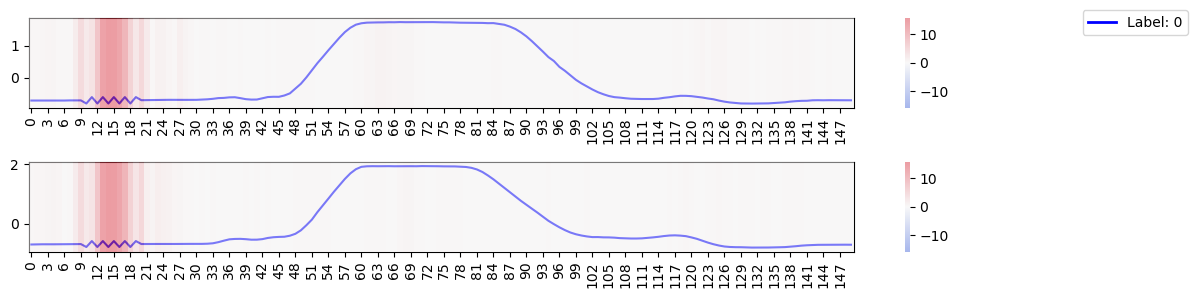

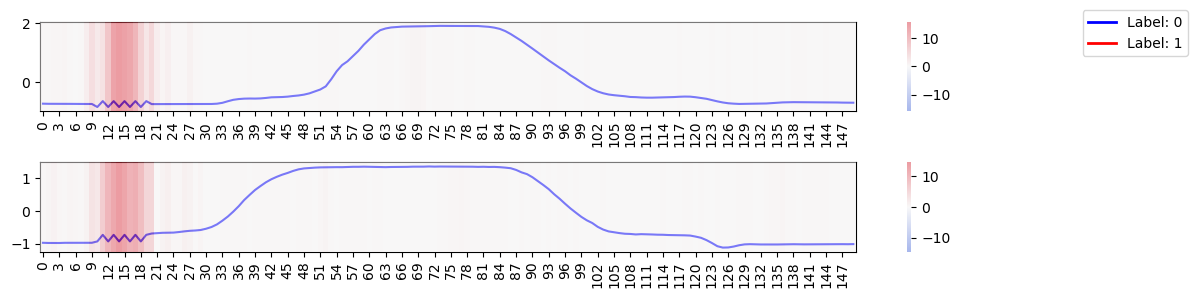

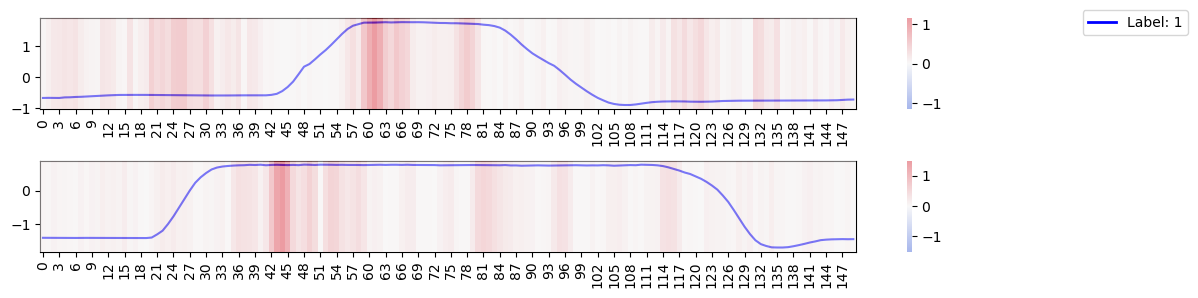

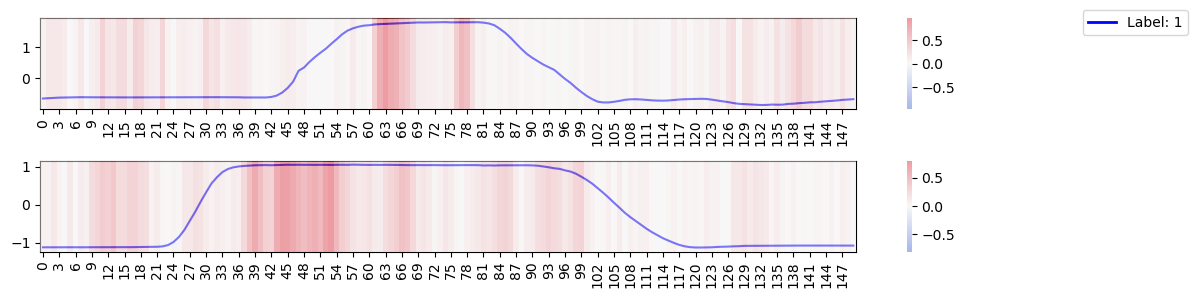

In [53]:


attr_class = None
for xai_name in ['Saliency']:
    attr_save_dir = f'attributions/{model_name}/{task}/{xai_name}/'

    if not os.path.isfile(os.path.join(attr_save_dir, 'test_exp.pkl')):
        attr, _ = get_attr(model, test_x, None, None,
                          save_dir=os.path.join(attr_save_dir, 'test_exp.pkl'),
                          xai_name=xai_name, target_class=attr_class)
    else:
        attr = pickle_load_from_file(os.path.join(attr_save_dir, 'test_exp.pkl'))
        attr = attr['attributions']
    for i in range(5):
        interval = 30
        plot_multiple_images_with_attribution(test_x[0+i*interval:interval+i*interval], test_y[0+i*interval:interval+i*interval], 2,figsize=(12,3), 
                                      use_attribution=True,
                                      attributions=attr[0+i*interval:interval+i*interval],
                                      normalize_attribution=True,
                                      save_path=None,
                                      test_y = test_y[0+i*interval:interval+i*interval],
                                     )


# shapelet

In [54]:
from pyts.transformation import ShapeletTransform

window_sizes = np.arange(8,12)
# window_sizes
st = ShapeletTransform(window_sizes=window_sizes,random_state=42, sort=True, n_jobs=8)
X_new = st.fit_transform(test_x.reshape(test_x.shape[0],test_x.shape[-1]), np.argmax(test_y,axis=1))
# X_new = st.fit_transform(test_x, test_y)

KeyboardInterrupt: 

dict_keys(['sample', 'start', 'end', 'idx'])


(-7.45, 156.45, -2.8377521850000003, 4.592443885)

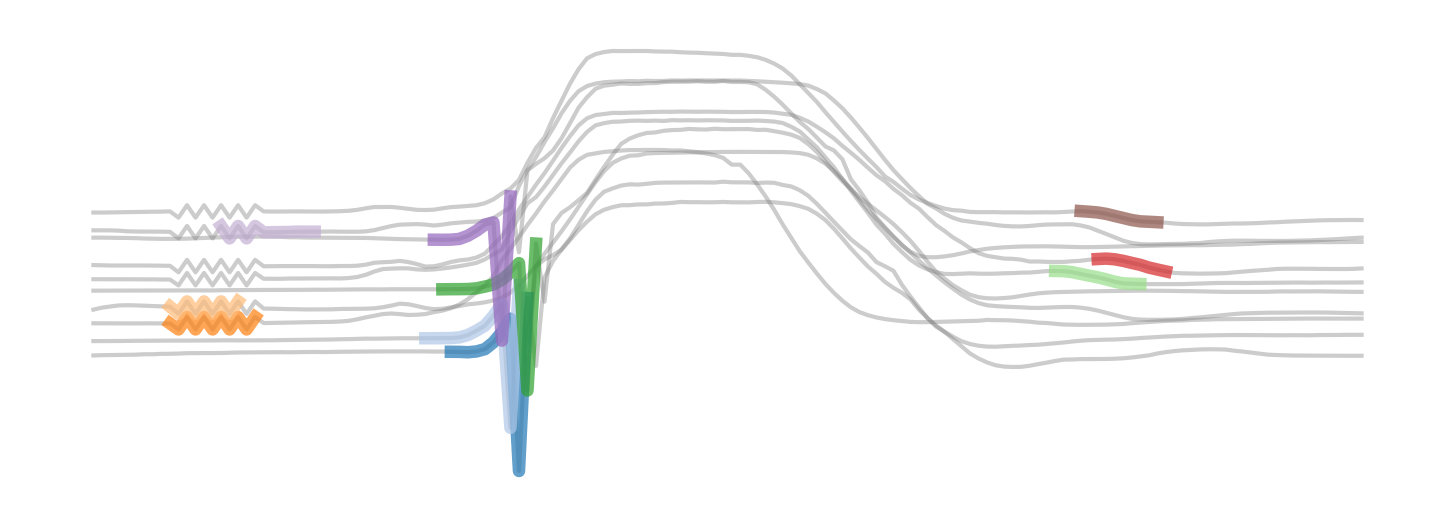

In [80]:
test_y_one_hot = enc1.inverse_transform(test_y)

results = []

# plt.figure(figsize=(6, 4))
# count = 0
# for i, index in enumerate(st.indices_):
#     idx, start, end = index

#     item = {'sample': test_x[idx], 'start': start, 'end': end, 'idx': idx}
#     results.append(item)
    
#     print(index,test_y[idx])
    
#     if count > 10:
#         break
#     if test_y_one_hot[idx] == 0:
#         plt.plot(test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx], color='C{}'.format(i) ,
#                  label='Sample {}'.format(idx),alpha=0.3)
#         plt.plot(np.arange(start, end), test_x.reshape(test_x.shape[0],test_x.shape[-1])[idx, start:end],
#                  lw=2, color='C{}'.format(i))
#         count +=1
# plt.xlabel('Time', fontsize=12)
# plt.title('The 10 most discriminative shapelets for class 0', fontsize=14)
# plt.legend(loc='best', fontsize=8)
# plt.show()

with open(f'./output/{task}/ST.pkl', 'rb') as f:
    st = pickle.load(f)
print(st[0].keys())
keys = ['sample', 'start', 'end', 'idx']

plt.figure(figsize=(6, 2), dpi=300)

for i, shapelet in enumerate(st[:10]):
    sample, start, end, idx = [shapelet[k] for k in keys]
    plt.plot(test_x[idx].flatten() + i * 0.25, lw=1, color='gray', alpha=0.4)

for i, shapelet in enumerate(st[:10]):
    sample, start, end, idx = [shapelet[k] for k in keys]
    plt.plot(np.arange(start, end + 1), 
             test_x[idx].flatten()[start:end + 1] + i * 0.25, 
             lw=3, alpha=0.7, color=plt.get_cmap('tab20')(i if i < 7 else i + 1))

plt.axis('off')

# pickle_save_to_file(results,f'./output/{task}/ST.pkl')

# with open(f'./output/{task}/ST.pkl', 'wb') as f:
#     pickle.dump(results,f)

In [67]:
from tslearn.shapelets import LearningShapelets

model = LearningShapelets(n_shapelets_per_size={3: 2})
model.fit(test_x.reshape(test_x.shape[0],test_x.shape[-1]), np.argmax(test_y,axis=1))
train_distances = model.transform(test_x.reshape(test_x.shape[0],test_x.shape[-1]))
test_distances = model.transform(test_x.reshape(test_x.shape[0],test_x.shape[-1]))
shapelets = model.shapelets_as_time_series_

2025-04-04 11:17:41.629905: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [69]:
shapelets.shape

(2, 3, 1)

# Implet

In [95]:
implets = implet_extractor(test_x, test_y, attr)

[96, 83, 47, 44, 127, 13, 46, 82, 33, 19]


(-7.45, 156.45, -2.8377521850000003, 4.592443885)

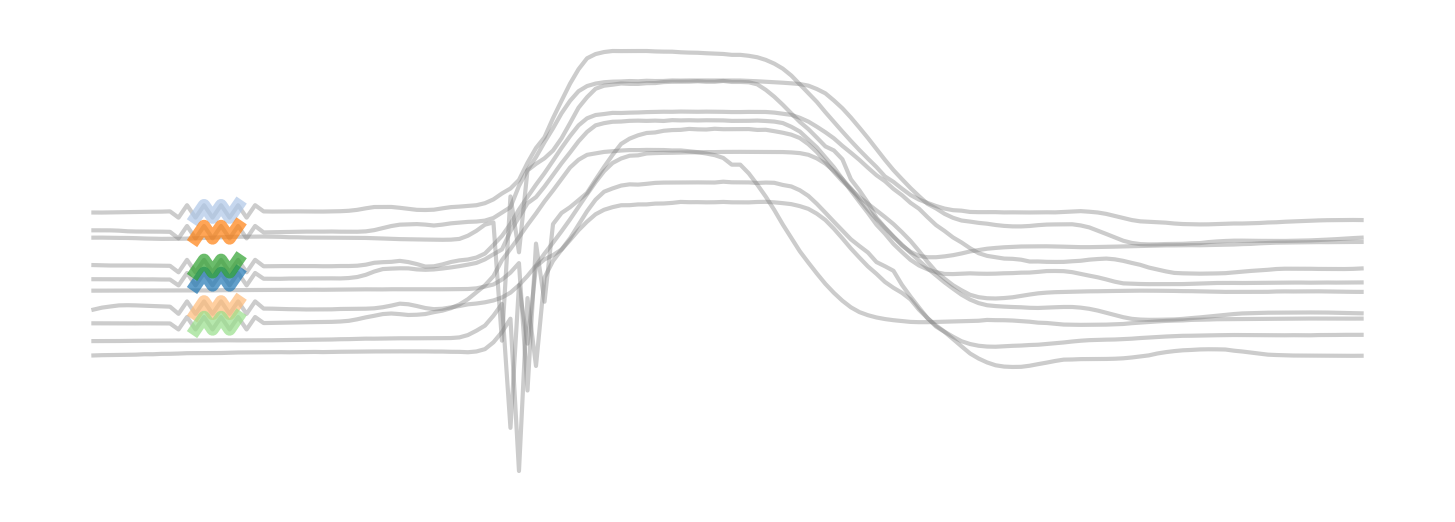

In [96]:
plt.figure(figsize=(6, 2), dpi=300)

for i, shapelet in enumerate(st[:10]):
    sample, start, end, idx = [shapelet[k] for k in keys]
    plt.plot(test_x[idx].flatten() + i * 0.25, lw=1, color='gray', alpha=0.4)

sample_indices = [shapelet['idx'] for shapelet in st[:10]]
print(sample_indices)
i = 0
for idx, _, _, _, start, end in implets:
    if idx in sample_indices:
        plt.plot(np.arange(start, end + 1), 
                 test_x[idx].flatten()[start:end + 1] + sample_indices.index(idx) * 0.25, 
                 lw=3, alpha=0.7, 
                 color=plt.get_cmap('tab20')(i if i < 7 else i + 1))
        i += 1

plt.axis('off')